# Intro

A fully convnet model to detect fishes. Steps:

- Create a data set of fish and no-fish
- Load all bounding boxes and create a mask for every image
- Create a fully convolutional network (ie. VGG - dense layers + a few conv layers)
  Traget values for the network are 22x40 masks
  
- Predict masks for test set
- Find the brightest contours on the mask, and take the biggest
- Crop a square around the center of the biggest contour 

Inspired by this work: http://rocknrollnerd.github.io/ml/2015/11/26/right-whales.html

Validation: 
Visually checking results

ToDo:
Augmentation for training and mask data 


Thanks to Naive shuai for bounding boxes and to Jeremy Howard for his incredibly useful lecture on fasti.ai.


In [1]:
%matplotlib inline
import utils#; reload(utils)
from utils import *
from __future__ import division, print_function


import os
import random

import numpy as np
import matplotlib.pyplot as plt

from glob import iglob, glob

from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array

from scipy.misc import imresize, toimage
import ujson as json
import cv2

ROOT_DIR = os.getcwd()
DATA_HOME_DIR = ROOT_DIR + '/data/'
%matplotlib inline



WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


In [4]:
DATA_HOME_DIR
path = DATA_HOME_DIR+"fishnofish/"
batch_size=16

In [5]:
anno_classes = ["Fish"]#['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']


### Loading data

In [14]:
# trn = get_data(path+'train', (360,640))
val = get_data(path+'valid', (360,640))
# test = get_data(path+'test', (360,640))

Found 450 images belonging to 2 classes.


In [10]:
#non_processed: 'results/test_640.dat'

In [6]:
#path = "data/fish/sample/"



(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

# raw_val_filenames[0]

Found 3327 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 12153 images belonging to 1 classes.


### Processing bounding boxes


In [16]:
bb_json = {}
for c in anno_classes:
    j = json.load(open('{}/all_fish_labels.json'.format(DATA_HOME_DIR, c), 'r'))
#     print ("Files with multiple bounding boxes: ")
    for  i , l in enumerate(j):
        if 'annotations' in l.keys() and len(l['annotations'])>0:
#             bb_json[l['filename'].split('/')[-1]] = sorted(
#                 l['annotations'], key=lambda x: x['height']*x['width'])[-1]
        #use all bounding boxes
            bb_json[l['filename'].split('/')[-1]] = l['annotations']
        
        #uncomment to see photos with more than 1 fish
#         if len(l['annotations']) > 1:
#             print (l['filename'] , ", index: ", i, ", num bbox: ",len(l['annotations']) )

In [17]:
# bb_json['img_01912.jpg']


In [18]:
#For any images that have no annotations, we'll create an empty bounding box.

empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}
training_null_count = 0 
valid_null_count = 0 

for f in raw_filenames:
    if not f in bb_json.keys():
#         print (f, " not found (training)")
        bb_json[f] = [empty_bbox]
        training_null_count += 1 
        
for f in raw_val_filenames:
    if not f in bb_json.keys(): 
#         print (f, " not found (validation)")
        bb_json[f] = [empty_bbox]
        valid_null_count += 1
        
         

In [19]:
# bb_json['img_00022.jpg']


In [20]:
print (training_null_count, valid_null_count)

420 60


In [21]:
bb_params = ['height', 'width', 'x', 'y']

#bb: an array of boxes
def convert_bb(boxes, size, resized_width=640.,resized_height=360. ):
    
    output = []
#     print (boxes)

    for bb in boxes:
    
        bb = [bb[p] for p in bb_params]


            # conversion factors
        conv_x = (resized_width / size[0])
        conv_y = (resized_height / size[1])


        bb[0] = bb[0]*conv_y#+10
        bb[1] = bb[1]*conv_x#+10

    #     bb[2] = max((bb[2]*conv_x - 10), 0)
    #     bb[3] = max((bb[3]*conv_y - 10), 0)
        bb[2] = max((bb[2]*conv_x), 0)
        bb[3] = max((bb[3]*conv_y), 0)

#         print (bb)
        
        output.append(bb)


    return output
    

In [22]:
sizes = [PIL.Image.open(path+'train/'+f).size for f in filenames]
raw_val_sizes = [PIL.Image.open(path+'valid/'+f).size for f in val_filenames]


In [23]:
trn_bbox = [convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)]
val_bbox = [convert_bb(bb_json[f], s) for f,s in zip(raw_val_filenames, raw_val_sizes)]

In [24]:
print (len(trn_bbox), len(val_bbox))

3327 450


In [25]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=1)

def show_bb(i):
    boxes  = val_bbox[i]
    plot(val[i])
    for bb in boxes:
        plt.gca().add_patch(create_rect(bb))

In [28]:
# show_bb(103)
#286 #18

### Create masks based on bounding boxes
this will serve as the prediction target

In [16]:
# bb_params = ['height', 'width', 'x', 'y']

def get_coordinates(bbox):
    height = bbox[0]
    width = bbox[1]
    
    #bottom left
    x0 = bbox[2] 
    y0 =  bbox[3]

    return [[x0,y0],[x0+width,y0],[x0+width,y0+height],[x0,y0+height]]


In [17]:
polygon_test = []

for box in val_bbox[103]:
    polygon_test.append(np.array(get_coordinates(box),np.int32))
# polygon_test

mask = np.zeros((360, 640), dtype="int32")
mask = cv2.fillPoly(mask, np.int32(polygon_test),255)


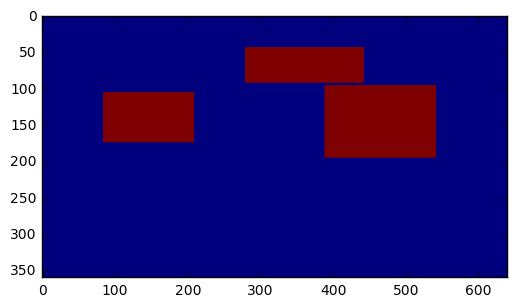

In [18]:
plt.imshow(mask)

Now that the sample is working, let's create our target patches in size 40x22

In [19]:
trn_bbox = [convert_bb(bb_json[f], s,resized_width=40,resized_height=22) for f,s in zip(raw_filenames, sizes)]
val_bbox = [convert_bb(bb_json[f], s,resized_width=40,resized_height=22) for f,s in zip(raw_val_filenames, raw_val_sizes)]

In [20]:
trn_targets = []
val_targets = [] 


#training bboxes
for i,b in enumerate(trn_bbox):
    
    #get individual fish bboxes
    mask_patches = []
    for box in trn_bbox[i]:
        mask_patches.append(np.array(get_coordinates(box),np.int32))    
    
    
    mask = np.zeros((22, 40), dtype="int32")
    
    mask = cv2.fillPoly(mask, np.int32(mask_patches),255)
    trn_targets.append(mask)
    
    
#validation bboxes
for i,b in enumerate(val_bbox):
    
    mask_patches = []
    for box in val_bbox[i]:
        mask_patches.append(np.array(get_coordinates(box),np.int32))
        
        
    mask = np.zeros((22, 40), dtype="int32")
    mask = cv2.fillPoly(mask, np.int32(mask_patches),255)
    val_targets.append(mask)    

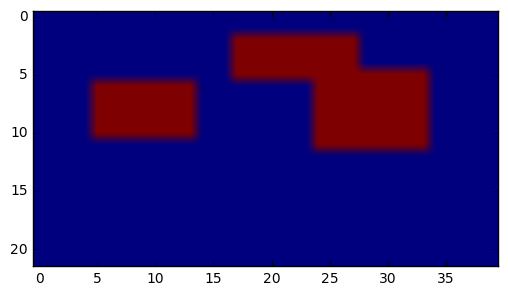

In [21]:
plt.imshow(val_targets[103])

In [22]:
np.array(trn_targets).shape

(3327, 22, 40)

## Model Training

#### Loading data

In [35]:
#preprocessed photos
# trn = load_array(DATA_HOME_DIR+"fishnofish/results/trn_640_processed_1.5.dat")
# val = load_array(DATA_HOME_DIR+"fishnofish/results/val_640_processed_1.5.dat")
# test = load_array(DATA_HOME_DIR+"fishnofish/results/test_640_processed_1.5.dat


#raw photos
test = load_array(path+"results/test_640.dat")
# val = load_array(path+"results/val_640.dat")

Preprocessing conv features

In [47]:
#in case we need to precompute vgg features
# vgg640 = Vgg16BN((360, 640)).model
# vgg640.pop()
# vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

# conv_trn_feat = vgg640.predict(trn, batch_size=32, verbose=1)
# conv_val_feat = vgg640.predict(val, batch_size=32, verbose=1)
# conv_test_feat = vgg640.predict(test, batch_size=32, verbose=1)

# save_array(DATA_HOME_DIR+"fishnofish/results/conv_trn_640_processed_1.5.dat", conv_trn_feat)
# save_array(DATA_HOME_DIR+"fishnofish/results/conv_val_640_processed_1.5.dat", conv_val_feat)
# save_array(DATA_HOME_DIR+"fishnofish/results/conv_test_640_processed_1.5.dat", conv_test_feat)


450/450 [==============================] - 55s    


In [36]:
# conv_test_feat = load_array(DATA_HOME_DIR+"fishnofish/results/conv_test_640_processed_1.5.dat")
# conv_val_feat = load_array(DATA_HOME_DIR+"fishnofish/results/conv_val_640_processed_1.5.dat")

#from raw files (no-preprocessing)
# conv_trn_feat = load_array(path+"results/conv_trn_640.dat")
# conv_val_feat = load_array(path+"results/conv_val_640.dat")
conv_test_feat = load_array(path+"results/conv_test_640.dat")



#### Defining Model

In [7]:
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop()
# print (vgg640.input_shape, vgg640.output_shape)
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=[ 'accuracy'])

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1282: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1282: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1282: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


In [19]:
conv_layers,_ = split_at(vgg640, Convolution2D)
conv_model = Sequential(conv_layers)


In [20]:
nf=128; p=0.6

# from keras.layers.pooling import GlobalMaxPooling2D
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Dropout(p/3),

        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Dropout(p/2),

        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Dropout(p),
        
        Convolution2D(1,3,3, border_mode='same')
#         GlobalAveragePooling2D(),
#         Activation('softmax')
    ]

In [21]:
model = Sequential(get_lrg_layers())

In [22]:
# model.summary()

In [23]:
model.compile(Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [33]:
trn_targets = np.array(trn_targets)
val_targets = np.array(val_targets)

trn_reshaped = trn_targets.reshape(trn_targets.shape[0],1,trn_targets.shape[1],trn_targets.shape[2])
val_reshaped = val_targets.reshape(val_targets.shape[0],1,val_targets.shape[1],val_targets.shape[2])
# trn_targets.reshape(trn_targets.shape[0],1,trn_targets.shape[1],trn_targets.shape[2]).shape

In [34]:
model.fit(conv_trn_feat, trn_reshaped, batch_size=batch_size, nb_epoch=5, 
             validation_data=(conv_val_feat, val_reshaped))

Train on 3327 samples, validate on 450 samples
Epoch 1/5
3327/3327 [==============================] - 31s - loss: 1727.0304 - acc: 0.0476 - val_loss: 1481.3690 - val_acc: 0.0812
Epoch 2/5
3327/3327 [==============================] - 31s - loss: 1059.6666 - acc: 0.0412 - val_loss: 1047.4629 - val_acc: 0.1453
Epoch 3/5
3327/3327 [==============================] - 31s - loss: 834.7938 - acc: 0.0737 - val_loss: 944.1535 - val_acc: 0.3189
Epoch 4/5
3327/3327 [==============================] - 31s - loss: 690.7226 - acc: 0.0950 - val_loss: 891.0274 - val_acc: 0.3494
Epoch 5/5
3327/3327 [==============================] - 31s - loss: 592.5092 - acc: 0.1131 - val_loss: 977.3064 - val_acc: 0.3510


Training more (even with smaller learning rates) has made the results worse, so i'll stop here.

In [41]:
# model.save_weights(path+"models/bboxdetector_lr3_good_visual_accuracy.hd5")
# model.save_weights(DATA_HOME_DIR+"fishnofish/models/bboxdetector_lr3_1.5contrast_multibbox.hd5")
# model.load_weights(DATA_HOME_DIR+"fishnofish/models/bboxdetector_lr3_1.5contrast_multibbox.hd5")

model.save_weights(DATA_HOME_DIR+"fishnofish/models/bboxdetector_lr3_nopreprocess_multibbox.hd5")


In [42]:
model.optimizer.lr = 1e-5
model.fit(conv_trn_feat, trn_reshaped, batch_size=batch_size, nb_epoch=5, 
             validation_data=(conv_val_feat, val_reshaped))

Train on 3327 samples, validate on 450 samples
Epoch 1/5
3327/3327 [==============================] - 31s - loss: 516.1465 - acc: 0.1142 - val_loss: 804.7495 - val_acc: 0.1152
Epoch 2/5
3327/3327 [==============================] - 31s - loss: 452.1440 - acc: 0.1084 - val_loss: 827.0817 - val_acc: 0.0733
Epoch 3/5
3327/3327 [==============================] - 31s - loss: 411.7697 - acc: 0.1128 - val_loss: 784.7364 - val_acc: 0.3597
Epoch 4/5
3327/3327 [==============================] - 31s - loss: 368.6608 - acc: 0.1121 - val_loss: 823.8638 - val_acc: 0.1505
Epoch 5/5
3327/3327 [==============================] - 31s - loss: 336.3535 - acc: 0.1144 - val_loss: 790.2713 - val_acc: 0.1072


In [24]:
# model.save_weights(DATA_HOME_DIR+"fishnofish/models/bboxdetector_lr5_nopreprocess_multibbox.hd5")
model.load_weights(DATA_HOME_DIR+"fishnofish/models/bboxdetector_lr5_nopreprocess_multibbox.hd5")



In [52]:
model.optimizer.lr = 1e-7
model.fit(conv_trn_feat, trn_reshaped, batch_size=batch_size, nb_epoch=5, 
             validation_data=(conv_val_feat, val_reshaped))

Train on 3327 samples, validate on 450 samples
Epoch 1/5
3327/3327 [==============================] - 31s - loss: 315.4581 - acc: 0.1070 - val_loss: 791.2316 - val_acc: 0.1209
Epoch 2/5
3327/3327 [==============================] - 31s - loss: 295.6031 - acc: 0.1126 - val_loss: 789.9285 - val_acc: 0.2021
Epoch 3/5
3327/3327 [==============================] - 31s - loss: 279.0887 - acc: 0.1099 - val_loss: 795.7281 - val_acc: 0.1948
Epoch 4/5
3327/3327 [==============================] - 31s - loss: 265.2959 - acc: 0.1167 - val_loss: 802.0773 - val_acc: 0.1822
Epoch 5/5
3327/3327 [==============================] - 31s - loss: 251.0207 - acc: 0.1150 - val_loss: 798.6570 - val_acc: 0.2069


In [78]:
model.save_weights(DATA_HOME_DIR+"fishnofish/models/bboxdetector_lr7_nopreprocess_multibbox.hd5")


In [36]:
num_image = 339

l = model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-1].output)

def get_cm(inp, label):
    conv = conv_fn([inp,0])[0, label] #conf_fn shape (1, 1, 22, 40)
    return scipy.misc.imresize(conv, (360,640), interp='nearest')


# plt.imshow(to_plot(val[num_image]))

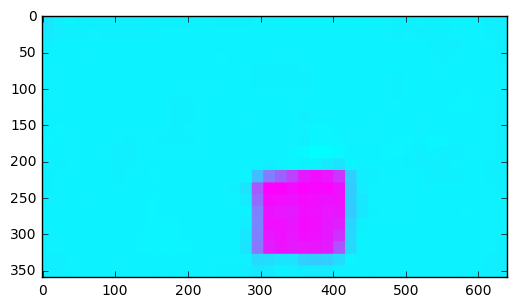

In [54]:
inp = np.expand_dims(conv_val_feat[num_image], 0)
np.round(model.predict(inp)[0],2)


cm = get_cm(inp, 0)
plt.imshow(cm, cmap="cool")

#### Verifing performance on test data

In [37]:
#bad: 489 486 513 580  629
#fantastic:  200 48
#easy: 413 412 195 918

#fixed 999
#got worse 522 200
# 522 fixed after 
num_image = 390
# plt.imshow(to_plot(test[num_image]))


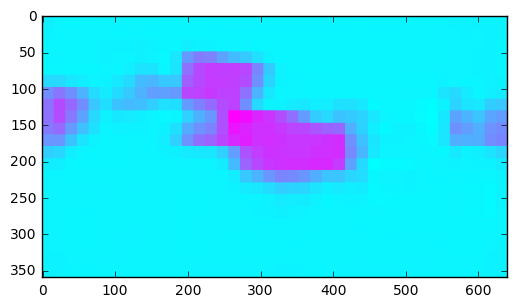

In [71]:
inp = np.expand_dims(conv_test_feat[num_image], 0)
# inp = np.round(model.predict(inp)[0],2)


# cm = get_cm(inp, 0)
conv = conv_fn([inp,0])[0, 0] #conf_fn shape (1, 1, 22, 40)
cm =  scipy.misc.imresize(conv, (360,640), interp='nearest')
plt.imshow(cm, cmap="cool")

### Crop hotzones

In [72]:
ret, thresh = cv2.threshold(cm, 200, 255, 0)
im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

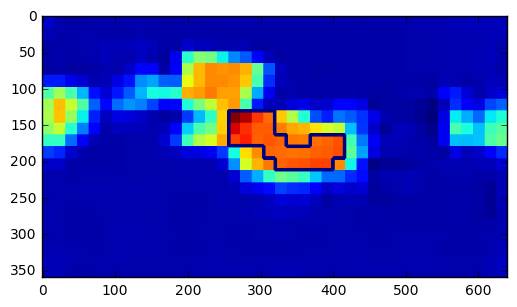

In [73]:
plt.imshow(cv2.drawContours(cm, contours, -1, (0,255,0), 3))


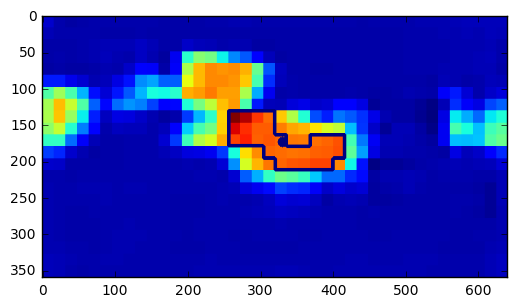

In [74]:
# find a better function than surface. total sum of pixels inside?
def find_biggest_contour(contours):
    
    # nofish? 
    
    
#     if len(contours) == 1 :
#         return 0
    
    #if more than one contour, find the biggest contour surface
    biggest_contour_index = -1 
    biggest_contour_surface = 0

    i = 0
    for c in contours:
        # compute the center of the contour
        area = cv2.contourArea(c)
        if area > biggest_contour_surface:
            biggest_contour_surface = area
            biggest_contour_index = i
        i += 1
        
    return biggest_contour_index        
        
#find center of the biggest contour

i = find_biggest_contour(contours)
M = cv2.moments(contours[i])
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
    

# draw the contour and center of the shape on the image
cv2.circle(cm, (cX, cY), 7, (0, 0, 0), -1)
plt.imshow(cv2.drawContours(cm, [contours[i]], -1, (0, 255, 0), 2))


In [214]:
print (cX,cY)

345 253


In [75]:
crop_width = 450
width = 640
height = 360

x = max(cX - crop_width/2, 0)
y = max(cY - crop_width/2, 0)
    
if x + crop_width > width:
    x = width - crop_width
if y + crop_width > height:
    y = height - crop_width

x = int(x)
y = int(y)

In [76]:
print (x,y)

105 -90


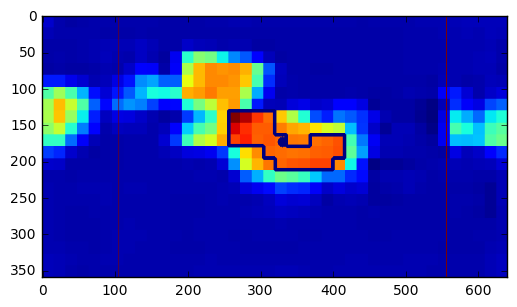

In [77]:
# plt.gca().add_patch(plt.Rectangle((0, 0), 10, 10, color='red', fill=False, lw=2))
cv2.circle(cm, (cX, cY), 7, (0, 0, 0), -1)
cv2.rectangle(cm,(x,y),(x+crop_width,y+crop_width),color=(255, 255, 255))
plt.imshow(cv2.drawContours(cm, [contours[i]], -1, (0, 255, 0), 2))



### Crop all test data

In [80]:
test_path = DATA_HOME_DIR+"fishnofish/test/test_stg1/"
export_path = DATA_HOME_DIR+'/cropped_nof_excl/test/multibox_nopreproc_noaug/'

crop_width = 450


In [38]:
for i,t in enumerate(raw_test_filenames):
    
    
    if i < 289: #remove this to generate all crops
        continue
        
        
        
    test_img = cv2.imread(test_path+t)
    img_width = test_img.shape[1]
    img_height = test_img.shape[0]
    
#     plt.imshow(test_img)
    #predict
    inp = np.expand_dims(conv_test_feat[i], 0)
    conv = conv_fn([inp,0])[0, 0] #conf_fn shape (1, 1, 22, 40)
    cm = scipy.misc.imresize(conv, (img_height,img_width), interp='nearest')
    
    #find contours
    ret, thresh = cv2.threshold(cm, 200, 255, 0)
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    
    #find center of the biggest contour

    i = find_biggest_contour(contours)
    M = cv2.moments(contours[i])
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    
    #calculate boundries of bounding box
    x = max(cX - crop_width/2, 0)
    y = max(cY - crop_width/2, 0)

    if x + crop_width > img_width:
        x = img_width - crop_width
    if y + crop_width > img_height:
        y = img_height - crop_width
        
    x = int(x)
    y = int(y)

    
###### plot bounding box    
#     cv2.rectangle(cm,(x,y),(x+crop_width,y+crop_width),color=(255, 255, 255))
#     plt.imshow(cv2.drawContours(cm, [contours[i]], -1, (0, 255, 0), 2))

##### crop the image and save
    crop_img = test_img[y:y+crop_width, x:x+crop_width]
#     plt.imshow(crop_img)
#     cv2.imwrite(export_path+t,crop_img)
    break

#### Stage 2 predictions

In [15]:
target_size  = (360,640)
test_batches = image.ImageDataGenerator().flow_from_directory(path+"test", target_size=target_size,
                class_mode=None, shuffle=False, batch_size=32)

Found 12153 images belonging to 1 classes.


In [26]:
conv_test_feat = conv_model.predict_generator(test_batches, len(test_filenames))


In [28]:
save_array(path+"results/stg2_conv_test_feat_640.dat",conv_test_feat)

In [ ]:
# stg2_hotzone_predictions = model.predict(conv_test_feat, batch_size=32)
# save_array(path+"data/stg2_hotzone_pred_noaug.dat",stg2_hotzone_predictions)

generating crops

In [29]:
test_path = DATA_HOME_DIR+"fishnofish/test/test_stg2/"
export_path = DATA_HOME_DIR+'/cropped_nof_excl/test/stg2_multibox_noaug/'

crop_width = 450


In [33]:
l = model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-1].output)

def get_cm(inp, label):
    conv = conv_fn([inp,0])[0, label] #conf_fn shape (1, 1, 22, 40)
    return scipy.misc.imresize(conv, (360,640), interp='nearest')


# find a better function than surface. total sum of pixels inside?
def find_biggest_contour(contours):
    
    # nofish? 
    
    
#     if len(contours) == 1 :
#         return 0
    
    #if more than one contour, find the biggest contour surface
    biggest_contour_index = -1 
    biggest_contour_surface = 0

    i = 0
    for c in contours:
        # compute the center of the contour
        area = cv2.contourArea(c)
        if area > biggest_contour_surface:
            biggest_contour_surface = area
            biggest_contour_index = i
        i += 1
        
    return biggest_contour_index       

In [47]:

for i,t in enumerate(raw_test_filenames):
    
    print ("processing file {}".format(i+1))
        
    test_img = cv2.imread(test_path+t)
    img_width = test_img.shape[1]
    img_height = test_img.shape[0]
    
#     plt.imshow(test_img)

    #predict
    inp = np.expand_dims(conv_test_feat[i], 0)
    conv = conv_fn([inp,0])[0, 0] #conf_fn shape (1, 1, 22, 40)
    cm = scipy.misc.imresize(conv, (img_height,img_width), interp='nearest')
    
    #find contours
    ret, thresh = cv2.threshold(cm, 200, 255, 0)
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    
    #find center of the biggest contour

    i = find_biggest_contour(contours)
    M = cv2.moments(contours[i])
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    
    #calculate boundries of bounding box
    x = max(cX - crop_width/2, 0)
    y = max(cY - crop_width/2, 0)

    if x + crop_width > img_width:
        x = img_width - crop_width
    if y + crop_width > img_height:
        y = img_height - crop_width
        
    x = int(x)
    y = int(y)

    
###### plot bounding box    
#     cv2.rectangle(cm,(x,y),(x+crop_width,y+crop_width),color=(255, 255, 255))
#     plt.imshow(cv2.drawContours(cm, [contours[i]], -1, (0, 255, 0), 2))

##### crop the image and save
    crop_img = test_img[y:y+crop_width, x:x+crop_width]
#     plt.imshow(crop_img)
    cv2.imwrite(export_path+t,crop_img)

#     break

processing file 1
processing file 2
processing file 3
processing file 4
processing file 5
processing file 6
processing file 7
processing file 8
processing file 9
processing file 10
processing file 11
processing file 12
processing file 13
processing file 14
processing file 15
processing file 16
processing file 17
processing file 18
processing file 19
processing file 20
processing file 21
processing file 22
processing file 23
processing file 24
processing file 25
processing file 26
processing file 27
processing file 28
processing file 29
processing file 30
processing file 31
processing file 32
processing file 33
processing file 34
processing file 35
processing file 36
processing file 37
processing file 38
processing file 39
processing file 40
processing file 41
processing file 42
processing file 43
processing file 44
processing file 45
processing file 46
processing file 47
processing file 48
processing file 49
processing file 50
processing file 51
processing file 52
processing file 53
pr